# SLT-CE-5: Mean Field Approximation

LEGI = 19 917 558

<p style="background-color:#adebad;">
In this coding exercise we will implement a Meand Field Approximation approach and evaluate its performance on two problems:  
    <br> 1) The 2D Ising model (aka image reconstruction model) and  </li>
<br> 2) A Wine Dataset <b>different from the one in Coding Exercise 2</b>. 
</p>

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt23_lecture08.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise8.pdf)

[3] [Tutorial notes](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial8.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

<p style="background-color:#adebad;">In the first part of the coding exercise (Sections 4.0-5.0) we will use the mean field
approximation to solve the 2D Ising model (aka image riconstruction model). 
See also the tutorial [3] and exercise [2] -  the model originates from Section 8.3.3 of [5].
<br><br>
Your task is to apply/implement the mean field approximation and then compare it to the MCMC (for which we provide you an implementation below).
</p>

## Setup

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.ndimage import convolve
import time
from sklearn.cluster import KMeans
import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import random
import warnings
from scipy.spatial.distance import pdist, cdist, squareform
# Suppress all warnings (TSNE plot gives a lot of warnings)
warnings.filterwarnings("ignore")


We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

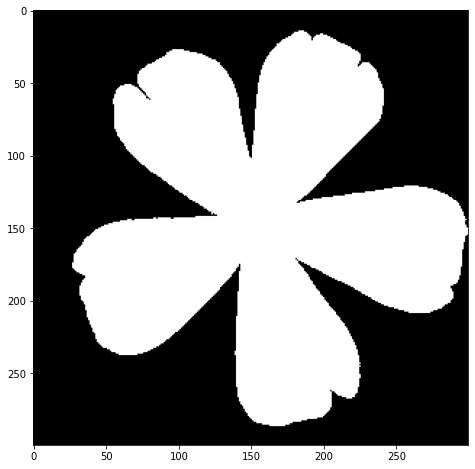

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [5]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

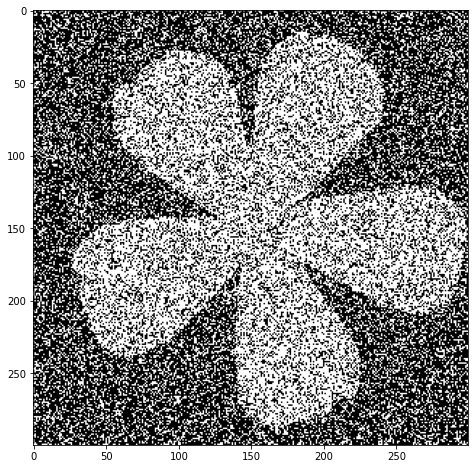

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as


In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [8]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

In [9]:
energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION)

-300855.94

Estimating loss via mean squared error

In [10]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [11]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [12]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300855.94


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Briefly recap the theory of the mean field approximation. 
    <br> (You can choose to describe only one of the many derivation given in the tutorial [3], e.g., variational upper bound.)  
</p>


When performing maximum entropy inference, we encounter the Gibbs distribution:
$$ P_\beta(c) = \frac{1}{Z(\beta)} \exp{(-\beta R(c))}, $$

where $ Z(\beta) $ is the normalization factor that sums across all possible $ c \in \mathcal{C} $. However, computing $ Z(\beta) $ directly becomes computationally infeasible when $ |\mathcal{C}| $ is exponential. To address this, the Mean Field approximation suggests approximating the Gibbs distribution by choosing a factorizable distribution denoted as $Q(c, \theta) = \prod_{i \le n} q_i(c_i)$ and minimizing the Kullback-Leibler divergence between Q and $P_\beta$. By making this approximation, we can easily compute $Z(\beta)$ in polynomial time.

<p style="background-color:#adebad;">
With the help of [2,3], explain the algorithm for solving image denoising using mean field approximation.
    <br>
    (Please try to be consistent in notation/symbols used here and in the previous question - same quantities should be denoted with the same symbol.)
</p>

The Ising model's energy function is defined as:

$$ E(\sigma) = -\lambda \sum_{i=1}^N h_i \sigma_i - \sum_{i,j=1}^N J_{ij}\sigma_i \sigma_j $$

Here, N represents the number of pixels, h denotes the noisy image, σ represents the denoised image, and $ J_{ij}\lambda \geq 0 $.

By applying the Mean Field approximation, we can efficiently calculate the partition function by considering an energy function of the form $ E'(\sigma) = - \sum_{i=1}^N h'_i \sigma_i $. Using this approximation, we can derive the denoised images as approximations given by $ \sigma_k' = \tanh[\beta(\sum_{i \neq k} J_{ki}\sigma_i' + \lambda h_k)] $. We can then refine these approximations by iteratively updating $ \sigma_k' $.



<p style="background-color:#adebad;">
Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the 'epochs' parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.
    Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Explain clearly the differences between them.
    <br>1) Does your implementation converge faster? 
    <br>2) What are the disadvantages and advantages?
<br><br>
Consider running the comparison on another image to prove your point.
Also, feel free to replace our implementation of MCMC with your own.
</p>

In [13]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [14]:
def meanfield(noisy_image, original_image, epochs, temperature=1, lambda_hyp=0.1, kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            noisy_image (np.ndarray): noisy image matrix
            original_image (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations
            temperature (float): Temperature parameter (default: 1)
            lambda_hyp (float): Hypothesis parameter (default: 0.1)

    Returns:
            reconstructed_image (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
            deltas (np.ndarray): Norms of changes in the image estimates recorded during the sampling process (for plotting)
    """
    
    energies = []
    losses = []
    reconstructed_image = noisy_image.copy()

    for _ in range(epochs):
        mean_field_sum = convolve(reconstructed_image, kernel)
        reconstructed_image = np.tanh((mean_field_sum + lambda_hyp * noisy_image) / temperature)
        
        energies.append(energy(reconstructed_image, original_image))
        losses.append(mse_loss(reconstructed_image, original_image))

    return  reconstructed_image, np.asarray(energies), np.asarray(losses)

In [15]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, **kwargs):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses= method(img_noisy_observation, img_original, epochs, **kwargs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

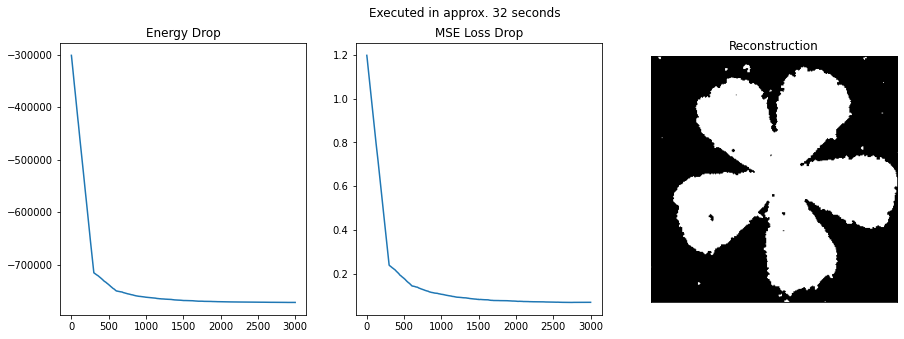

In [16]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

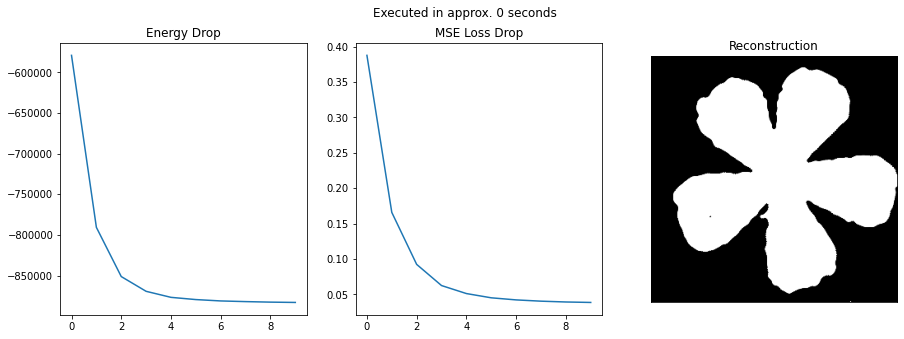

In [17]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

<p style="background-color:#adebad;">
Compare and analyze performance
</p>


- The mean field approximation algorithm converges much faster than the Metropolis algorithm.
- The qualitive performance of the MFA is qualitative much better than the Metropolis algorithm

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
Comment on the convergence of the method by answering these two questions.
    <br>1) How can we tell if the mean field convereged? 
    <br>2) Do we always reach the global optimum?
</p>

1) In the mean field approximation, convergence can be determined by monitoring the change or convergence of certain quantities during the iterative process.

    * **Delta Convergence**: Monitor the difference or change between estimated images in successive iterations. If this difference (delta) between consecutive estimates becomes small or converges to zero, it suggests that the algorithm has reached a stable solution. Plotting the deltas over iterations can provide insights into the convergence behavior.

    * **Energy Convergence**: Track the decrease in the energy function over iterations. If the energy function reaches a plateau or stabilizes, it indicates convergence. Plotting the energy values can help visualize the convergence behavior.


2) The MFA algorithm does not guarantee reaching the global optimum. However, employing an asynchronous update scheme (see Theorem 1 of Lecture Notes on MFA) for parameter updates ensures convergence to a local optimum of the free energy function within the factorial distribution space.



<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the temperature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. 
    <br>1) Can you explain the behaviour? 
    <br>2) Do you see a difference in the reconstraction at different temperature?
</p>

Recontruction using a temperature of 1, a lambda value of 0.1 and the kernel with 8 neighborns


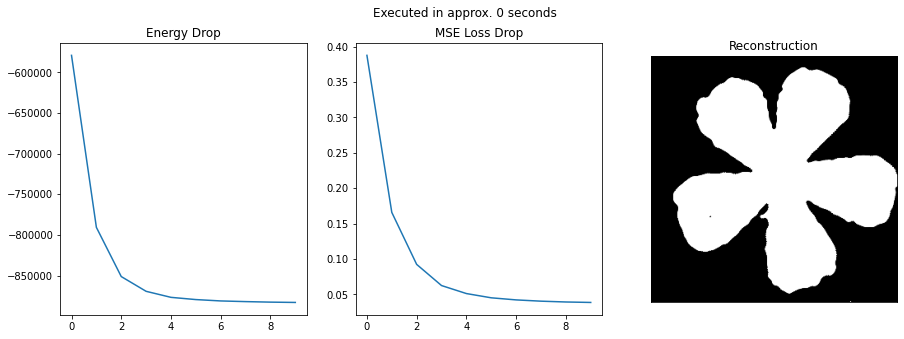

Recontruction using a temperature of 1, a lambda value of 0.1 and the kernel with 4 neighborns


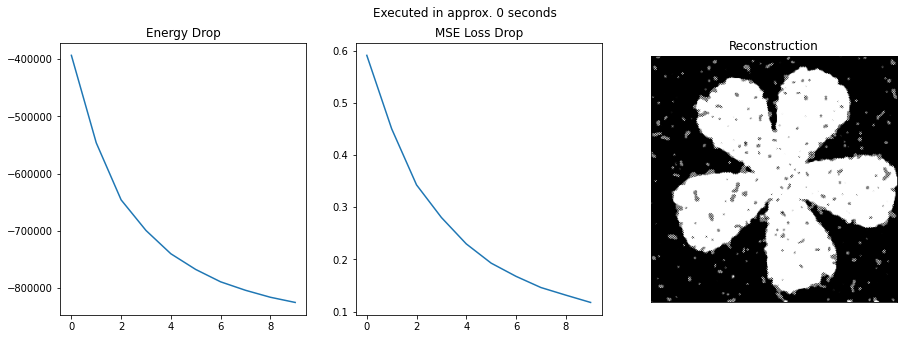

Recontruction using a temperature of 1, a lambda value of 0.5 and the kernel with 8 neighborns


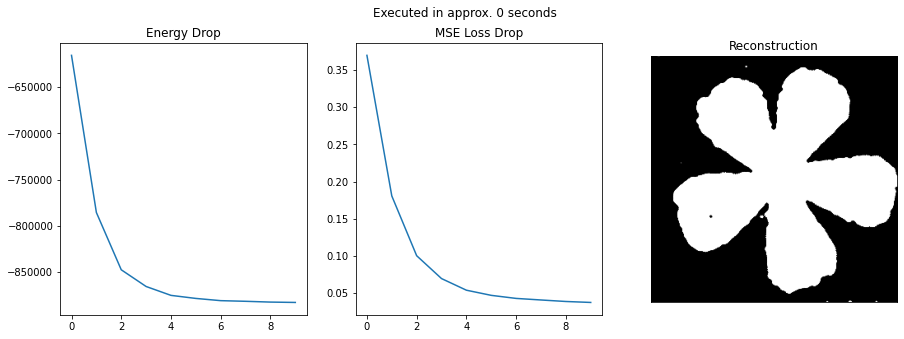

Recontruction using a temperature of 1, a lambda value of 0.5 and the kernel with 4 neighborns


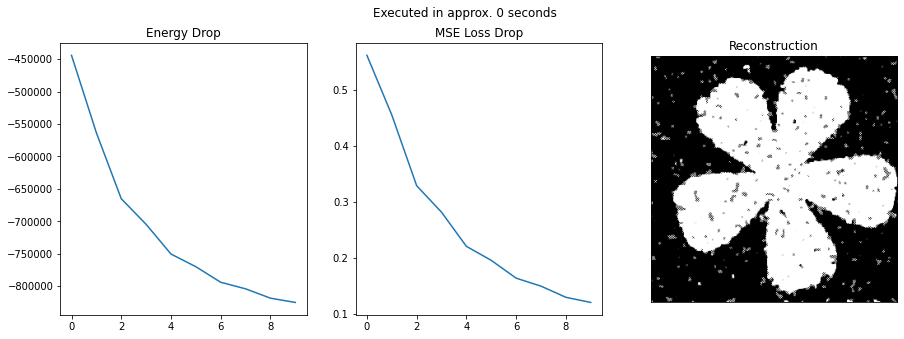

Recontruction using a temperature of 1, a lambda value of 1 and the kernel with 8 neighborns


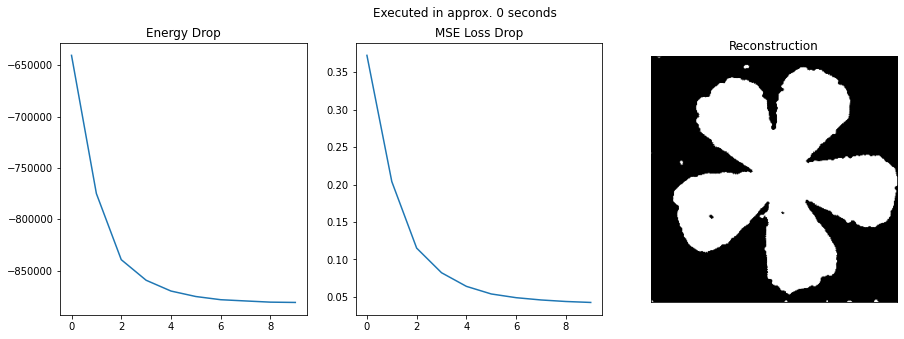

Recontruction using a temperature of 1, a lambda value of 1 and the kernel with 4 neighborns


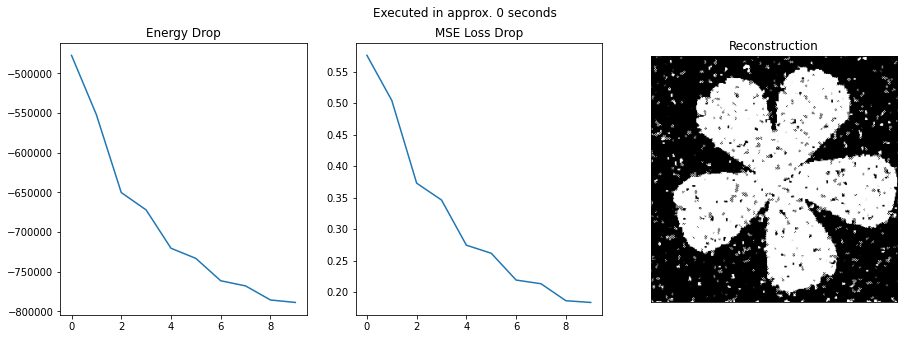

Recontruction using a temperature of 1, a lambda value of 2 and the kernel with 8 neighborns


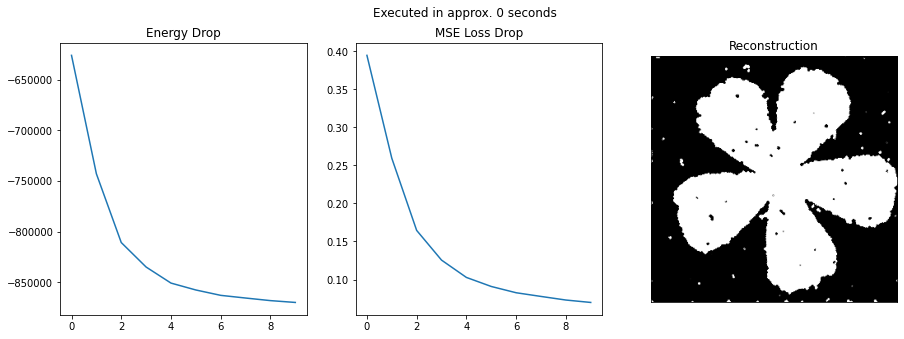

Recontruction using a temperature of 1, a lambda value of 2 and the kernel with 4 neighborns


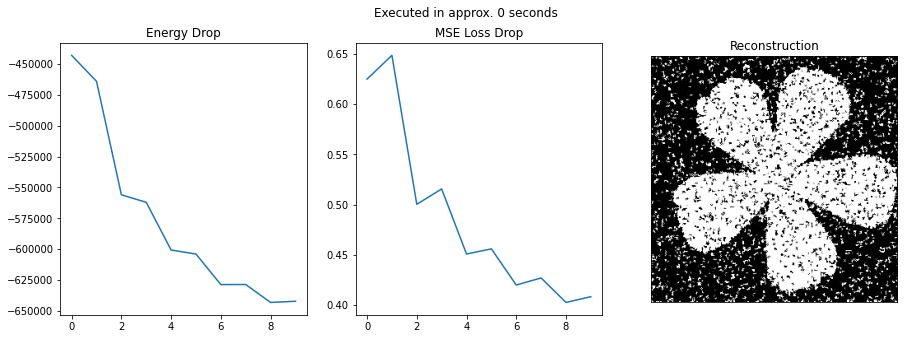

Recontruction using a temperature of 5, a lambda value of 0.1 and the kernel with 8 neighborns


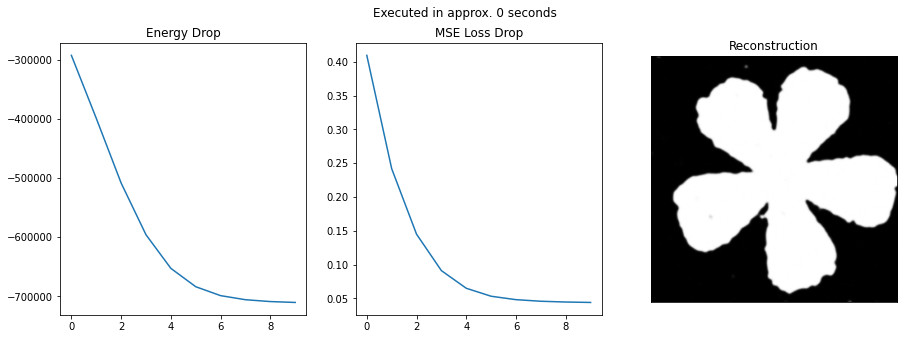

Recontruction using a temperature of 5, a lambda value of 0.1 and the kernel with 4 neighborns


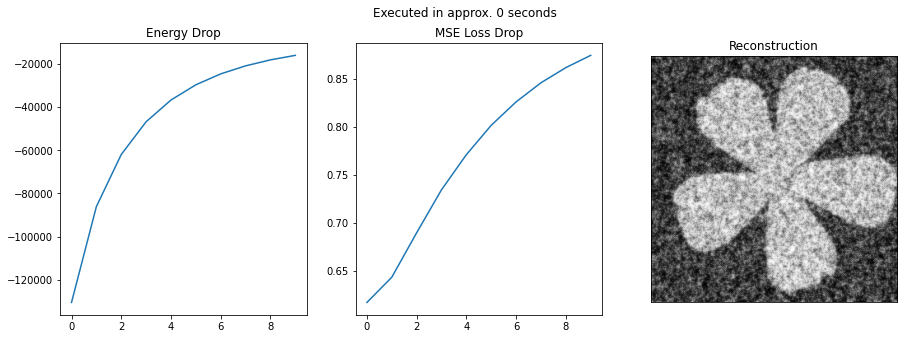

Recontruction using a temperature of 5, a lambda value of 0.5 and the kernel with 8 neighborns


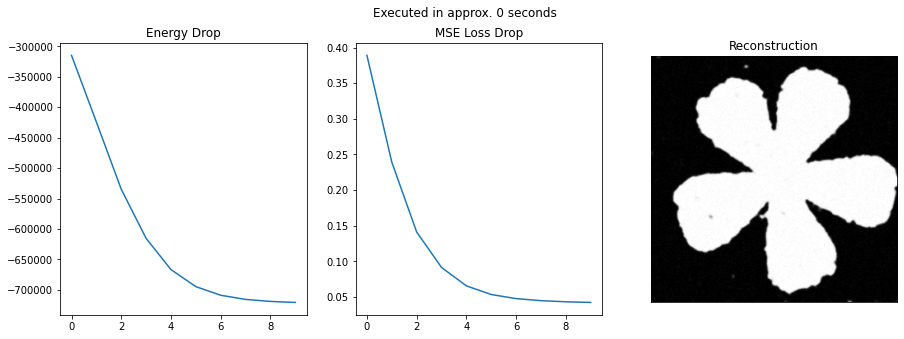

Recontruction using a temperature of 5, a lambda value of 0.5 and the kernel with 4 neighborns


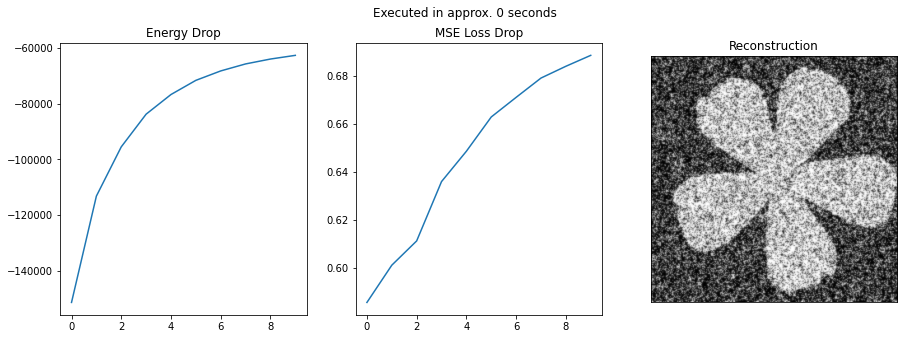

Recontruction using a temperature of 5, a lambda value of 1 and the kernel with 8 neighborns


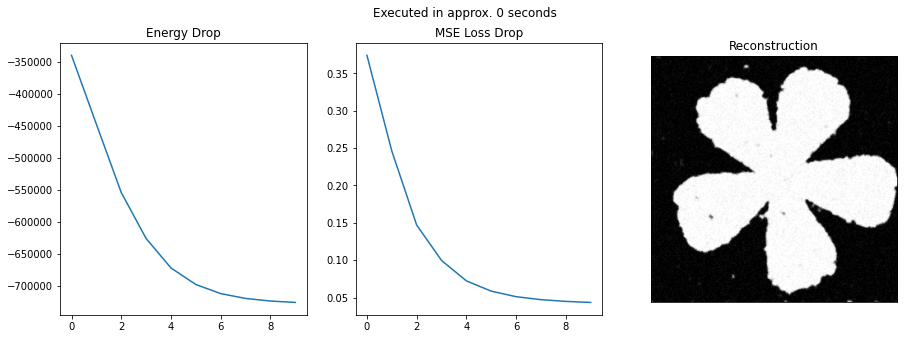

Recontruction using a temperature of 5, a lambda value of 1 and the kernel with 4 neighborns


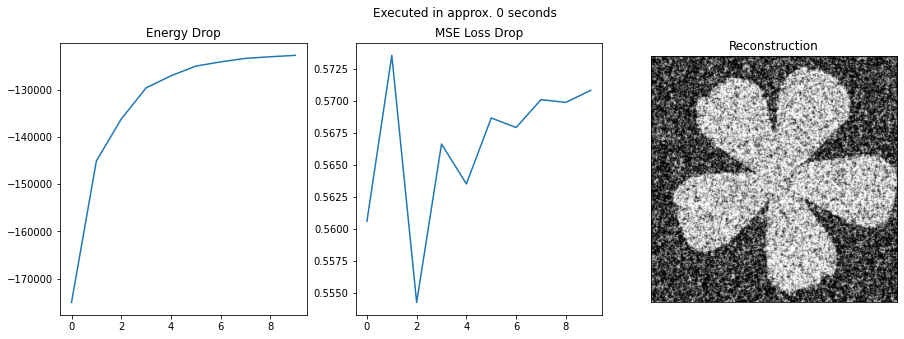

Recontruction using a temperature of 5, a lambda value of 2 and the kernel with 8 neighborns


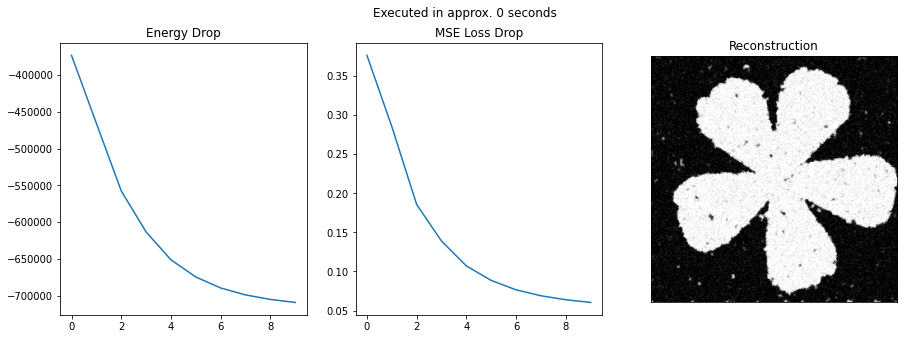

Recontruction using a temperature of 5, a lambda value of 2 and the kernel with 4 neighborns


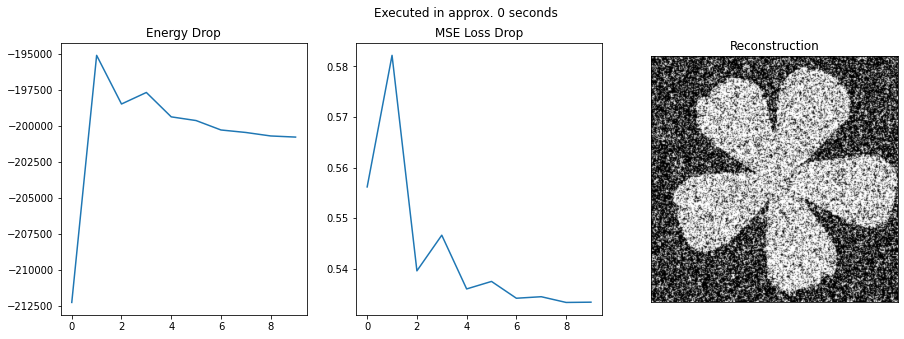

Recontruction using a temperature of 10, a lambda value of 0.1 and the kernel with 8 neighborns


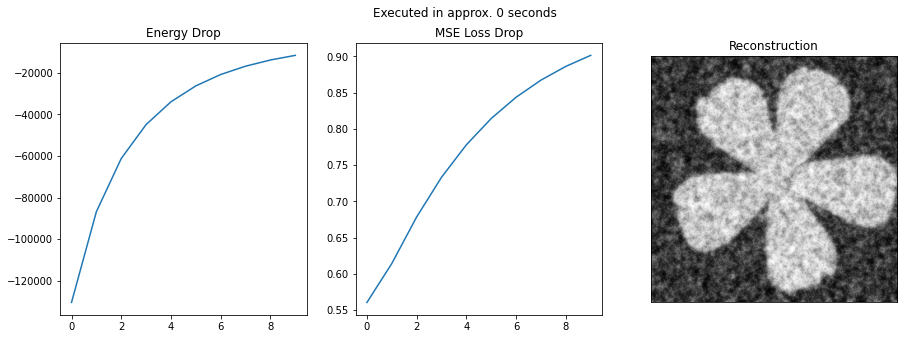

Recontruction using a temperature of 10, a lambda value of 0.1 and the kernel with 4 neighborns


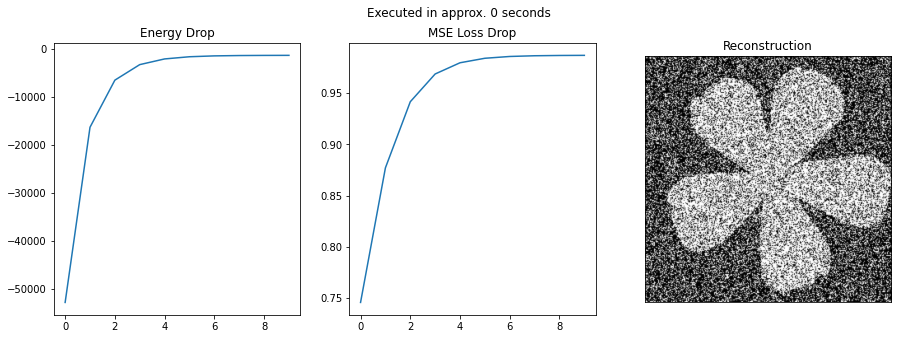

Recontruction using a temperature of 10, a lambda value of 0.5 and the kernel with 8 neighborns


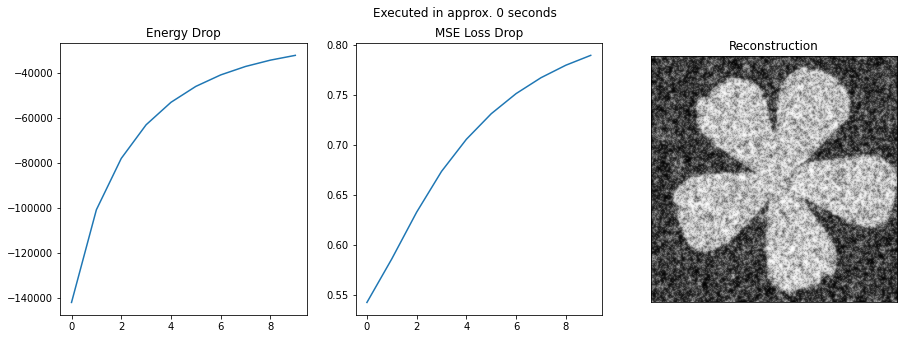

Recontruction using a temperature of 10, a lambda value of 0.5 and the kernel with 4 neighborns


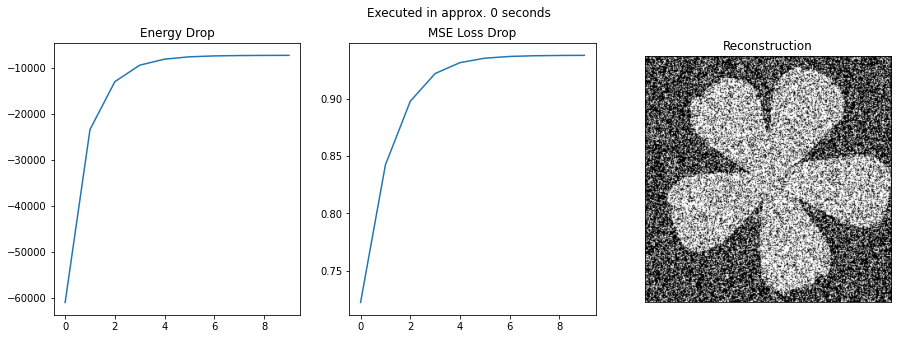

Recontruction using a temperature of 10, a lambda value of 1 and the kernel with 8 neighborns


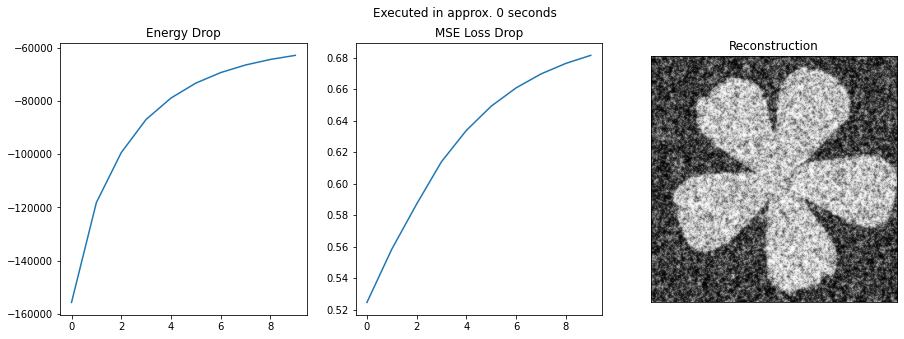

Recontruction using a temperature of 10, a lambda value of 1 and the kernel with 4 neighborns


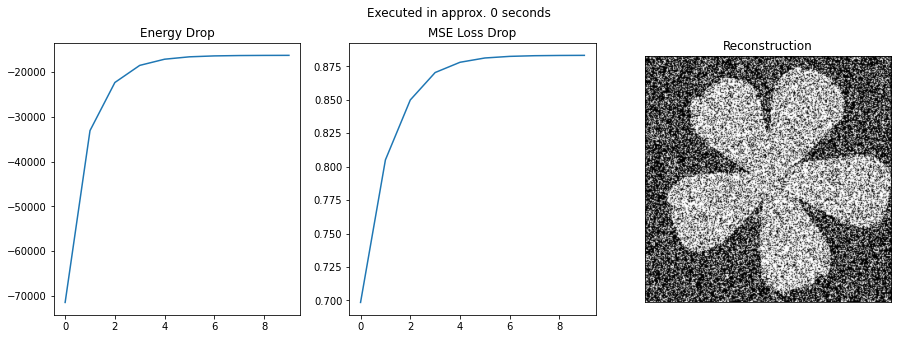

Recontruction using a temperature of 10, a lambda value of 2 and the kernel with 8 neighborns


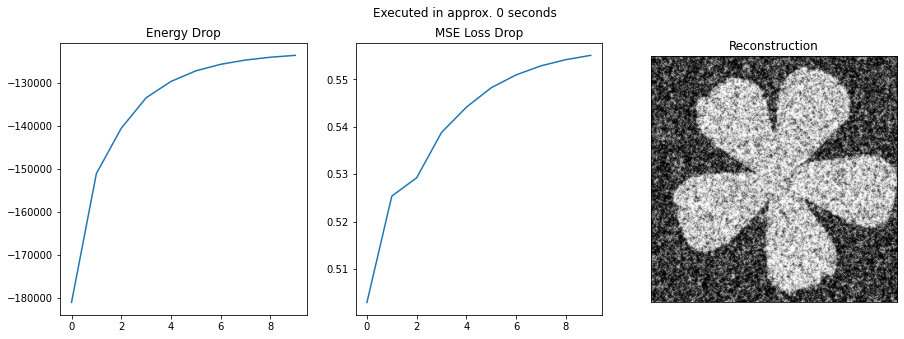

Recontruction using a temperature of 10, a lambda value of 2 and the kernel with 4 neighborns


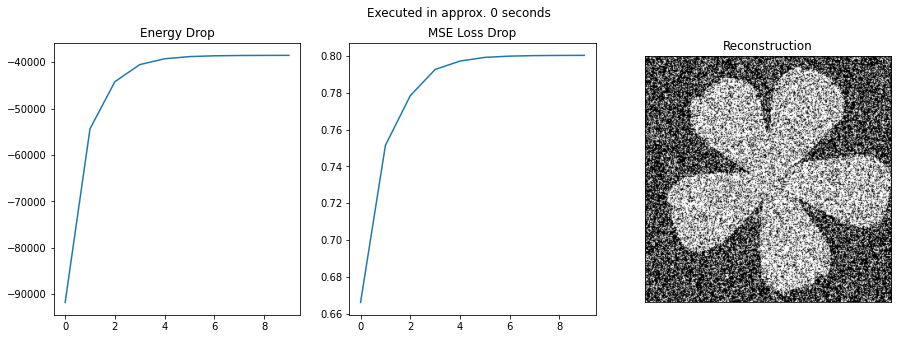

Recontruction using a temperature of 20, a lambda value of 0.1 and the kernel with 8 neighborns


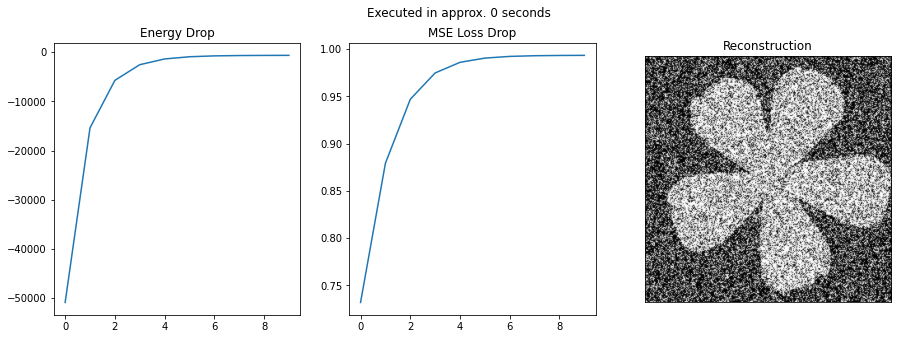

Recontruction using a temperature of 20, a lambda value of 0.1 and the kernel with 4 neighborns


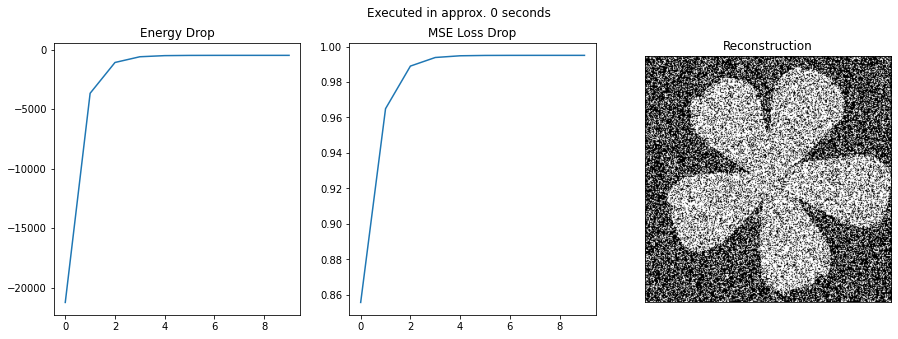

Recontruction using a temperature of 20, a lambda value of 0.5 and the kernel with 8 neighborns


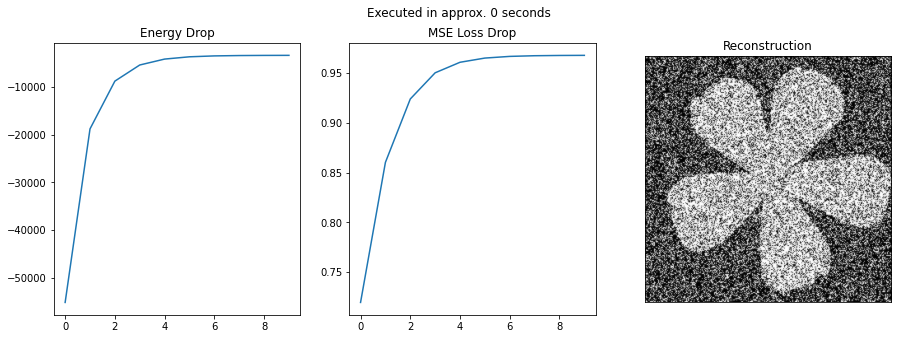

Recontruction using a temperature of 20, a lambda value of 0.5 and the kernel with 4 neighborns


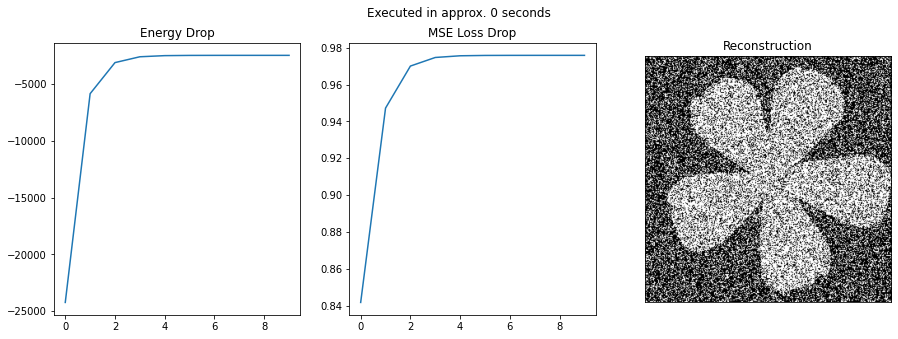

Recontruction using a temperature of 20, a lambda value of 1 and the kernel with 8 neighborns


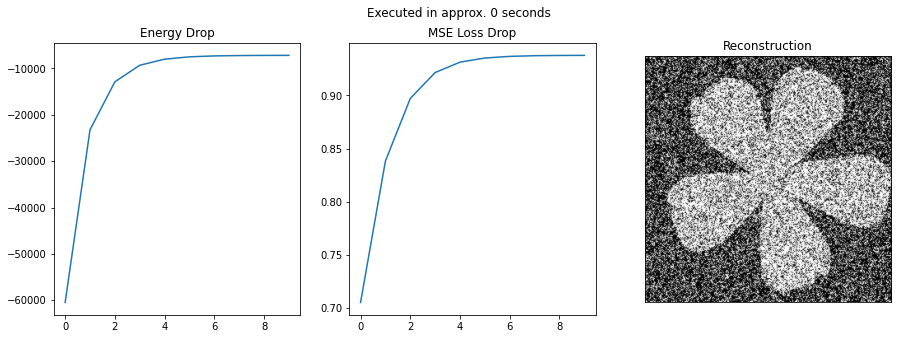

Recontruction using a temperature of 20, a lambda value of 1 and the kernel with 4 neighborns


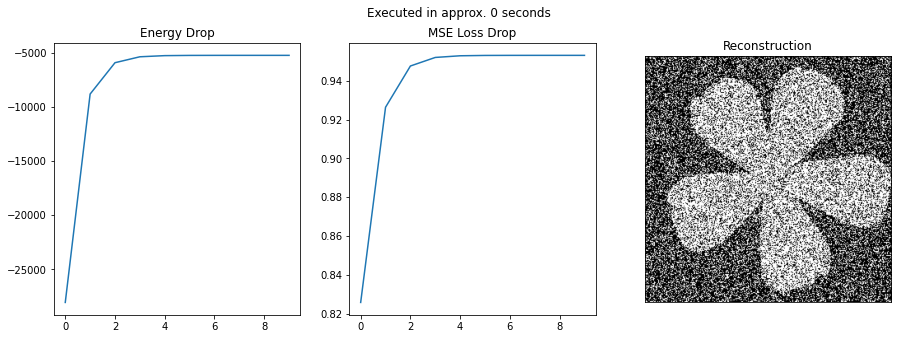

Recontruction using a temperature of 20, a lambda value of 2 and the kernel with 8 neighborns


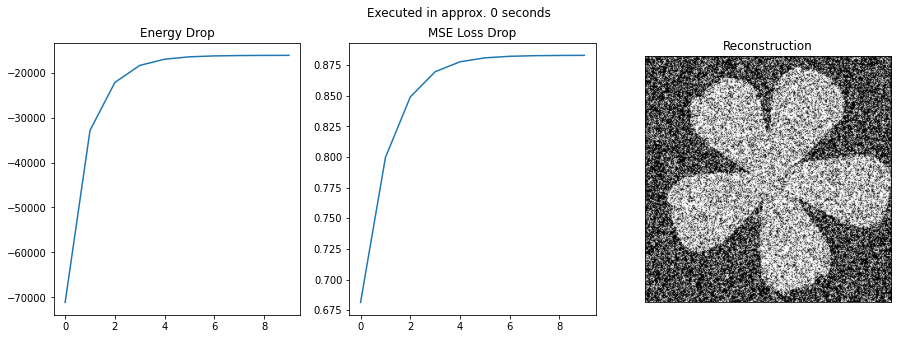

Recontruction using a temperature of 20, a lambda value of 2 and the kernel with 4 neighborns


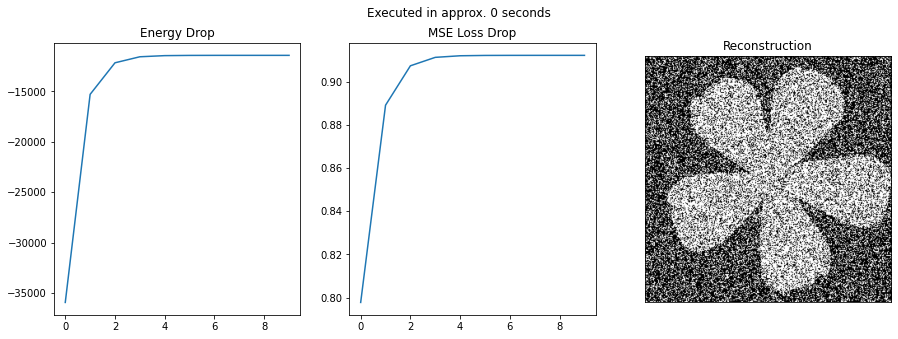

In [18]:
temp_values = [1, 5, 10, 20]
lambda_hyp_values = [0.1, 0.5, 1, 2]
kernel_values = [[np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]),8], [np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]), 4]]

for (temp, lambda_hyp, kernel) in itertools.product(temp_values, lambda_hyp_values, kernel_values):
    print("Recontruction using a temperature of " +str(temp) + ", a lambda value of " + str(lambda_hyp)+ " and the kernel with " + str(kernel[1]) + " neighborns")
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10, temperature = temp, lambda_hyp = lambda_hyp, kernel = kernel[0])
            


I considered three different parameters, hence the temperature, the lambda parameter of the MFA algorithm and convolutional kernel of the Ising model. Based on the evaluations and denoised images, while keeping two parameters fixed out of the three considered parameters (convolutional kernel, temperature, and lambda), we can observe the following influences:

1. **Temperature Parameter**:
   - The algorithm tends to perform better with a low temperature parameter, typically around 1.
   - Increasing the temperature to higher values leads to a decline in performance.
   - Lower temperature allows so for a more focused and accurate estimation, while higher temperatures introduce more randomness and reduce the quality of the denoised output.



2. **Convolutional Kernel**:
   - Using a kernel that considers 8 neighbors instead of 4 consistently improves performance.
   - The increased number of samples helps create a better mean field approximation by providing more information about the surrounding area of each pixel. This allows for a more accurate estimation of the current pixel's value, resulting in improved denoising performance.



3. **Lambda Parameter**:
   - The algorithm generally performs better with a small lambda value, typically around 0.1.
   - Slightly increasing the lambda parameter does not significantly impact performance.
   - Increase of the lambda parameters in the order of units tends to worsen the denoising performance.
   - This behavior can be attributed to the fact that higher lambda values force the reconstructed image to closely resemble the noisy image, potentially resulting in a less accurate denoised output.

These observations suggest that selecting an appropriate convolutional kernel, maintaining a low temperature, and using a small lambda parameter can lead to improved denoising performance in the meanfield algorithm.

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    For this and for all the following tasks, you have to use a different dataset: the <b>Wine data set</b> in [4] (this is <b>not</b> the Wine Dataset in previous coding exercise - please download the one in [4]). This data set contains three classes, see more detailed description online. 
    <br><br>
    Implement both (1) plain-vanilla k-means and (2) smooth k-means in mean field [1], and compare them on the Wine data set.
</p>

In [19]:
data = pd.read_csv("wine.data")
X = data.drop(data.columns[0], axis=1)
Y = data["1"]

scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = Y.values - 1

#Alignment of labels
def matching(y_pred, y_truth):
    labels_map = np.argmax(skl.metrics.cluster.contingency_matrix(y_pred, y_truth), axis=1)
    y_new = labels_map[y_pred]
    return y_new

#BIC score
def score_BIC(centers, labels, X, n_clusters):
    n = np.bincount(labels, minlength=n_clusters)
    N, d = X.shape

    cl_var = (1.0 / (N - n_clusters) / d) * sum([sum(cdist(X[np.where(labels == i)], [[centers][0][i]], 
             'euclidean')**2) for i in range(n_clusters)])

    bic_terms = n * np.log(n) - n * np.log(N) - ((n * d) / 2) * np.log(2 * np.pi * cl_var) - ((n - 1) * d / 2)

    return -np.sum(bic_terms) + 0.5 * n_clusters * np.log(N) * (d + 1)


In [20]:
class SmoothKMeans():
    def __init__(self, **kwargs):
        param = {"n_clusters": 3, "random_state": 42, "lambda_hyp" : .1, "dist_max_neighbour": 2, "temperature":1}
        self.__dict__.update(param)
        self.__dict__.update(kwargs)

    def fit(self, X):
        n = X.shape[0]
        np.random.seed(self.random_state)

        cluster_probs = np.random.uniform(low=0, high=1.0, size=(X.shape[0], self.n_clusters))
        cluster_probs /= np.sum(cluster_probs, axis=1)[:, np.newaxis]

        self.centroids = X.mean(axis=0) + np.random.uniform(-1, 1, size=(self.n_clusters, X.shape[1]))

        h_matrix = np.zeros((n, self.n_clusters))
        neighbour_matrix = np.zeros((n, n))
        neighbour_matrix[cdist(X, X) < self.dist_max_neighbour] = 1
        np.fill_diagonal(neighbour_matrix, 0)
        
        while True:
            old_h_matrix = h_matrix.copy()

            for u in np.random.permutation(n):
                norm_term = np.sum((X[u, :] - self.centroids) ** 2, axis=1)

                neighbours = cluster_probs[neighbour_matrix[u, :] == 1]
                N = np.tile(neighbours.sum(axis=0), (self.n_clusters, 1))
                np.fill_diagonal(N, 0)
                h_matrix[u, :] = norm_term - self.lambda_hyp * (N.sum(axis=0))

                cluster_probs[u, :] = self.compute_cluster_probs(h_matrix)[u, :]

            self.centroids = np.dot(cluster_probs.T, X) / cluster_probs.sum(axis=0)[:, np.newaxis]

            if np.linalg.norm(h_matrix - old_h_matrix) <= 1e-10:
                break
            
        return cluster_probs.argmax(1)

    def compute_cluster_probs(self, h_matrix):
        numerator = np.exp(-1 / self.temperature * h_matrix)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        return numerator/denominator

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
kmeans_cluster_labels = matching(kmeans.labels_, Y)

smooth_kmeans = SmoothKMeans(dist_max_neighbour=1, temperature=1).fit(X)
smooth_kmeans_cluster_labels= matching(smooth_kmeans, Y)

In [22]:
kmeans_accuracy = skl.metrics.accuracy_score(Y, kmeans_cluster_labels)
smooth_kmeans_accuracy = skl.metrics.accuracy_score(Y, smooth_kmeans_cluster_labels)

print(f"Accuracy (K-means): {kmeans_accuracy:.2f}")
print(f"Accuracy (Smooth K-means): {smooth_kmeans_accuracy:.2f}")


Accuracy (K-means): 0.97
Accuracy (Smooth K-means): 0.97


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

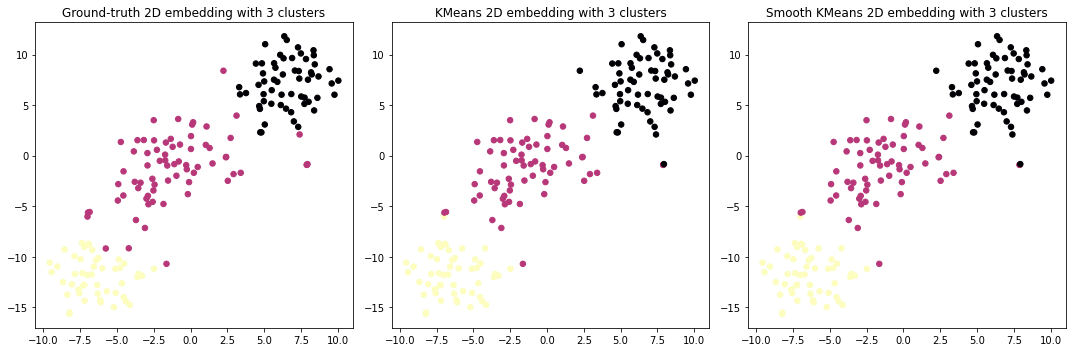

In [23]:
tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(tsne[:, 0], tsne[:, 1], c=Y, s=30, cmap='magma')
ax[0].set_title("Ground-truth 2D embedding with 3 clusters")

ax[1].scatter(tsne[:, 0], tsne[:, 1], c=kmeans_cluster_labels, s=30, cmap='magma')
ax[1].set_title("KMeans 2D embedding with 3 clusters")

ax[2].scatter(tsne[:, 0], tsne[:, 1], c=smooth_kmeans_cluster_labels, s=30, cmap='magma')
ax[2].set_title("Smooth KMeans 2D embedding with 3 clusters")

plt.tight_layout()
plt.show()


<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

In [24]:
def compute_purity(y, y_pred):
    confusion_matrix = skl.metrics.cluster.contingency_matrix(y, y_pred)
    purity = np.max(confusion_matrix, axis=0).sum() / len(y)
    return purity

k_means_purity = compute_purity(Y, kmeans.labels_)
smooth_k_means_purity = compute_purity(Y, smooth_kmeans)
print('KMeans purity:', k_means_purity)
print('Smooth KMeans purity:', smooth_k_means_purity)

KMeans purity: 0.9661016949152542
Smooth KMeans purity: 0.9661016949152542


Even if Smooth KMeans should perform better than vanilla KMeans, the improvement is only notable for some parameters value. 

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). 
    <br>1) Does it indicate 3 clusters? 
</p>

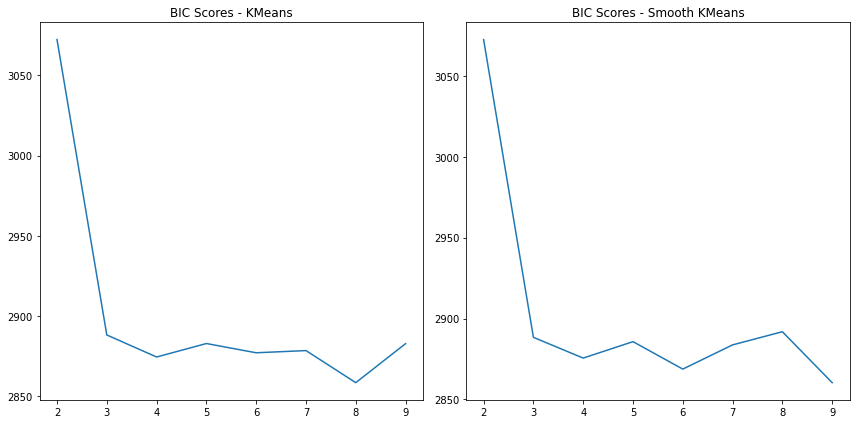

In [25]:
kmeans_score = []
smooth_kmeans_score = []
n_clusters = np.arange(2, 10)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))


for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X)
    y_kmeans = kmeans.predict(X)
    centroids_kmeans = kmeans.cluster_centers_
    kmeans_score.append(score_BIC(centroids_kmeans, y_kmeans, X, n))

axs[0].plot(n_clusters, kmeans_score)
axs[0].set_title('BIC Scores - KMeans')


for n in n_clusters:
    smooth_kmeans = SmoothKMeans(n_clusters=n, dist_max_neighbour=1)
    y_smooth_kmeans = smooth_kmeans.fit(X)
    smooth_kmeans_score.append(score_BIC(smooth_kmeans.centroids, y_smooth_kmeans, X, n))

axs[1].plot(n_clusters, smooth_kmeans_score)
axs[1].set_title('BIC Scores - Smooth KMeans')

plt.tight_layout()
plt.show()


For both algorithms at 3 clusters there is an elbow, which gives us a euristic to do model selection.

<p style="background-color:#adebad;">
2) How does the smooth k-means clustering solution change when varying the temperature of the mean field approximation?
</p>

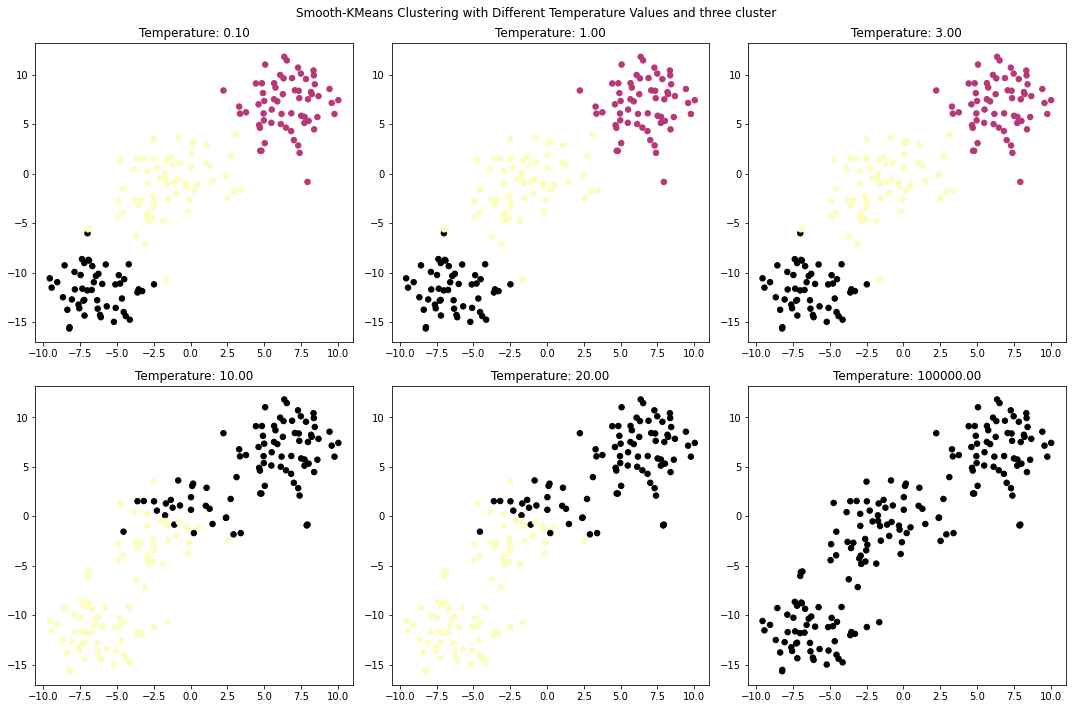

In [26]:
temperatures = [0.1, 1, 3, 10, 20, 1e5]
num_plots = len(temperatures)

fig, ax = plt.subplots(2, num_plots // 2, figsize=(5*num_plots // 2, 10))

ax = ax.flatten()


for i, t in enumerate(temperatures):
    smooth_kmeans_labels = SmoothKMeans(dist_max_neighbour=1, temperature=t).fit(X)

    ax[i].scatter(tsne[:, 0], tsne[:, 1], c=smooth_kmeans_labels, s=30, cmap='magma')
    ax[i].set_title("Temperature: {:.2f}".format(t))


fig.suptitle("Smooth-KMeans Clustering with Different Temperature Values and three cluster")
plt.tight_layout()
plt.show()

While for low temperature values the Smooth KMeans clustering correctly identifies the given number of clusters, for mid temperature values it only identifies 2 and for very high temperature values only one.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.